In [ ]:
import pandas as pd



# this only pulls the first 1000 rows. if you want the whole dataset take out the nrows = 1000
data=pd.read_csv('311_Service_Requests_from_2010_to_Present.tsv',delimiter='\t',encoding='utf-8-sig',low_memory=False, index_col  = 'Unique Key')
#we will use sample() function to select a random sample of size equivalent to 15% of the size of the dataset
df1 = data.sample(frac =.15, replace=True)


df.tail(1) #last N rows


In [ ]:
df2 = df1.copy()
df2.to_csv(r'C:\Users\faris\311_sample.csv')

##### cleaned the dataset
##### Took out some columns
##### took out some Agancys that dosen't have data or unclear data
##### filled missing data for the  closed dates series
##### Added some markdown
##### Added some titles to charts
##### added a heatmap using geopandas
##### Added a word cloud
##### added heat map using folium
##### last update 01/12/2019

In [1]:
import pandas as pd
import calendar
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-pastel')


#df = pd.read_csv('311_sample.csv')

In [2]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# pip install shapely --user
# pip install descartes --user
# pip install geopandas --user
# pip install gmplot --user
import descartes
import geopandas as gpd
import gmplot
from shapely.geometry import Point , Polygon
import folium
from folium import plugins

In [4]:
df = pd.read_csv('311_sample.csv'  , low_memory=False, index_col  = 'Unique Key' )
crs = { 'init' : 'EPSG:4326'}
 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382355 entries, 40955843 to 40741764
Data columns (total 40 columns):
Created Date                      382355 non-null object
Closed Date                       365795 non-null object
Agency                            382355 non-null object
Agency Name                       382355 non-null object
Complaint Type                    382355 non-null object
Descriptor                        376280 non-null object
Location Type                     293259 non-null object
Incident Zip                      367864 non-null object
Incident Address                  338326 non-null object
Street Name                       338298 non-null object
Cross Street 1                    246568 non-null object
Cross Street 2                    245880 non-null object
Intersection Street 1             122649 non-null object
Intersection Street 2             122465 non-null object
Address Type                      305482 non-null object
City                     

In [6]:
map_df= gpd.read_file('Neighborhood Tabulation Areas.geojson')
map_df.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,BK88,54005018.7472,047,Borough Park,39247.2280737,Brooklyn,3,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ..."
1,QN51,52488276.477,081,Murray Hill,33266.904811,Queens,4,"MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ..."
2,QN27,19726845.26,081,East Elmhurst,19816.7115378,Queens,4,"MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ..."
3,QN07,22887772.7683,081,Hollis,20976.3358374,Queens,4,"MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ..."
4,MN06,10647077.6122,061,Manhattanville,17040.6865482,Manhattan,1,"MULTIPOLYGON (((-73.94608 40.82126, -73.94640 ..."


In [7]:
df.shape

(382355, 40)

In [8]:
# keeping all these series and dropping  the rest becuase they have dupliucte values or unuseble for our analysis
df= df[['Created Date', 'Closed Date', 'Agency', 'Agency Name', 'City' ,
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip', 
       'Resolution Description', 'Borough', 'Open Data Channel Type' , "Longitude" , "Latitude"]]

In [11]:
#https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
# gives you a summry of the  missing values in a dataset
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df)

Your selected dataframe has 14 columns and 382355 Rows.
There are 8 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Location Type,0,89096,23.3,89096,23.3,object
Resolution Description,0,30743,8.0,30743,8.0,object
Longitude,0,22987,6.0,22987,6.0,float64
Latitude,0,22987,6.0,22987,6.0,float64
City,0,21673,5.7,21673,5.7,object
Closed Date,0,16560,4.3,16560,4.3,object
Incident Zip,0,14491,3.8,14491,3.8,object
Descriptor,0,6075,1.6,6075,1.6,object


In [12]:
# filtering data  
# displaying data only with NaN  
df.isna().sum()


Created Date                  0
Closed Date               16560
Agency                        0
Agency Name                   0
City                      21673
Complaint Type                0
Descriptor                 6075
Location Type             89096
Incident Zip              14491
Resolution Description    30743
Borough                       0
Open Data Channel Type        0
Longitude                 22987
Latitude                  22987
dtype: int64

In [13]:
(df.isna().mean() * 100).round(3)

Created Date               0.000
Closed Date                4.331
Agency                     0.000
Agency Name                0.000
City                       5.668
Complaint Type             0.000
Descriptor                 1.589
Location Type             23.302
Incident Zip               3.790
Resolution Description     8.040
Borough                    0.000
Open Data Channel Type     0.000
Longitude                  6.012
Latitude                   6.012
dtype: float64

### We see that the Closed Date has missing values so we fill it using todays date and assume that the complaints didn't get addressed


In [19]:
#we subset one of the misssing values to test if our dates are filled
df.loc[[42127222]]

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Resolution Description,Borough,Open Data Channel Type
Unique Key,,,,,,,,,,,
42127222,04/03/2019 11:24:02 AM,NaN,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Passenger,Street,11106,The Taxi and Limousine Commission (TLC) has re...,QUEENS,ONLINE


In [9]:
# getting todays date with timestap
TODAY =datetime.datetime.today()
# filling the missing data
df['Closed Date'].fillna(TODAY, inplace=True) 
#making sure we filled the right information
df.loc[[42127222]]

,Created Date,Closed Date,Agency,Agency Name,City,Complaint Type,Descriptor,Location Type,Incident Zip,Resolution Description,Borough,Open Data Channel Type,Longitude,Latitude
Unique Key,,,,,,,,,,,,,,
42127222,04/03/2019 11:24:02 AM,2019-12-02 05:42:11.592295,TLC,Taxi and Limousine Commission,ASTORIA,For Hire Vehicle Complaint,Driver Complaint - Passenger,Street,11106,The Taxi and Limousine Commission (TLC) has re...,QUEENS,ONLINE,-73.929044,40.760164


In [15]:
df.isna().sum()

Created Date                  0
Closed Date                   0
Agency                        0
Agency Name                   0
City                      21673
Complaint Type                0
Descriptor                 6075
Location Type             89096
Incident Zip              14491
Resolution Description    30743
Borough                       0
Open Data Channel Type        0
Longitude                 22987
Latitude                  22987
dtype: int64

In [10]:
df = df[df['Agency']!='DVS']
df = df[df['Agency']!='TAX']
df = df[df['Agency']!='DCAS']
df = df[df['Agency']!='ACS']
df = df[df['Agency']!='COIB']
#these agancys have some missing data or unclear at all informtion
df.shape



(382188, 14)

In [35]:
df['City'].mode()

0    BROOKLYN
dtype: object

In [37]:
df['City'].fillna(df['City'].mode()[0], inplace=True) 
df.isna().sum()


Created Date                  0
Closed Date                   0
Agency                        0
Agency Name                   0
City                          0
Complaint Type                0
Descriptor                 6075
Location Type             88929
Incident Zip              14324
Resolution Description    30728
Borough                       0
Open Data Channel Type        0
Longitude                 22820
Latitude                  22820
dtype: int64

### For us to do the analysis we first need to add new date columns

In [17]:
#adding the new dates column
df['just_time_open'] = pd.to_datetime(df['Created Date']).dt.strftime('%H:%M:%S')
df['just_close'] = pd.to_datetime(df['Closed Date'])
df['just_open'] = pd.to_datetime(df['Created Date'])
df['day of the week Open'] =  df['just_open'].dt.day_name()
df['day of the week close'] =  df['just_close'].dt.day_name()
df['Days to Close a Complaint' ] = -(df["just_open"] - df["just_close"]).astype("timedelta64[D]")
df['Month_open'] = df['just_open'].dt.month
 #https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
df['Month_open'] = df['Month_open'].apply(lambda x: calendar.month_abbr[x])


df.dtypes
#df.tail(10)

Created Date                         object
Closed Date                          object
Agency                               object
Agency Name                          object
City                                 object
Complaint Type                       object
Descriptor                           object
Location Type                        object
Incident Zip                         object
Resolution Description               object
Borough                              object
Open Data Channel Type               object
Longitude                           float64
Latitude                            float64
just_time_open                       object
just_close                   datetime64[ns]
just_open                    datetime64[ns]
day of the week Open                 object
day of the week close                object
Days to Close a Complaint           float64
Month_open                           object
dtype: object

In [18]:
df.head(3)

,Created Date,Closed Date,Agency,Agency Name,City,Complaint Type,Descriptor,Location Type,Incident Zip,Resolution Description,...,Open Data Channel Type,Longitude,Latitude,just_time_open,just_close,just_open,day of the week Open,day of the week close,Days to Close a Complaint,Month_open
Unique Key,,,,,,,,,,,,,,,,,,,,,
40955843,11/16/2018 10:38:06 PM,11/20/2018 02:07:48 AM,HPD,Department of Housing Preservation and Develop...,BRONX,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10451,The Department of Housing Preservation and Dev...,...,PHONE,-73.921346,40.829304,22:38:06,2018-11-20 02:07:48,2018-11-16 22:38:06,Friday,Tuesday,4.0,Nov
43346984,07/22/2019 02:28:34 AM,07/22/2019 09:10:37 PM,NYPD,New York City Police Department,BRONX,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10451,The Police Department responded to the complai...,...,MOBILE,-73.917610,40.823165,02:28:34,2019-07-22 21:10:37,2019-07-22 02:28:34,Monday,Monday,1.0,Jul
42059386,03/26/2019 09:36:43 PM,03/27/2019 09:18:23 PM,HPD,Department of Housing Preservation and Develop...,NEW YORK,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10016,The Department of Housing Preservation and Dev...,...,PHONE,-73.982678,40.741938,21:36:43,2019-03-27 21:18:23,2019-03-26 21:36:43,Tuesday,Wednesday,1.0,Mar


### we divided the time of day to bins  to see when will most complaints happen and when will they get addressed

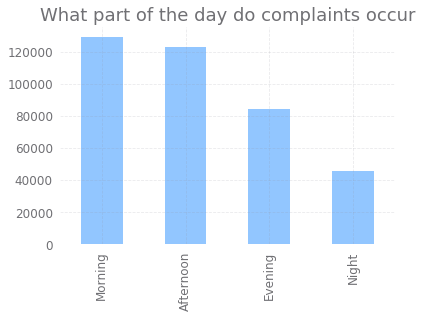

In [19]:
#part of day for calling and making a 311 requst
df_open = df['just_open']
#print (df)
#
df_open_cut=pd.cut(df_open.dt.hour,
               [0,6,12,18,23],
               labels=['Night','Morning','Afternoon','Evening'],
               include_lowest=True)
#add the part of day to our df
df['Part of day open'] =  df_open_cut
df_open_cut.value_counts().plot.bar(title= 'What part of the day do complaints occur')

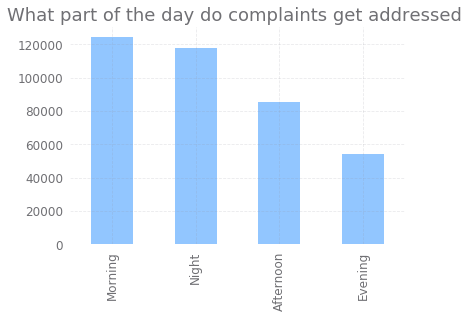

In [20]:

#part of day for calling and making a 311 requst
df_close = df['just_close']
#print (df)
#
df_close_cut=pd.cut(df_close.dt.hour,
               [0,6,12,18,23],
               labels=['Night','Morning','Afternoon','Evening'],
               include_lowest=True)
#add part of day close to our df
df['Part of day close'] =  df_close_cut
df_close_cut.value_counts().plot.bar(title= 'What part of the day do complaints get addressed ')

In [24]:
df_open_cut.value_counts()

Morning      129122
Afternoon    122853
Evening       84719
Night         45494
Name: just_open, dtype: int64

In [25]:
df_close_cut.value_counts()

Morning      124286
Night        101482
Afternoon     85749
Evening       70671
Name: just_close, dtype: int64

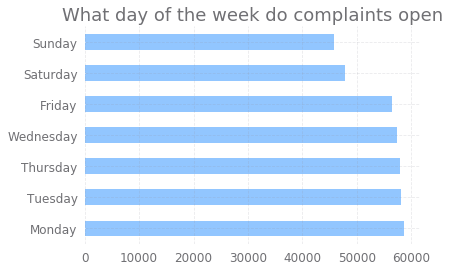

In [21]:
# what day in the week do people make a complaint
df['day of the week Open'].value_counts().plot.barh(title= 'What day of the week do complaints open')


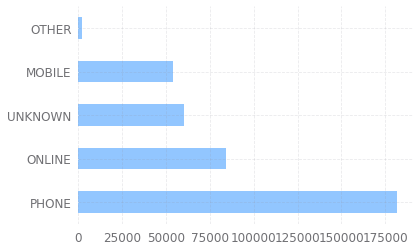

In [22]:
# whats mobile and how its deffrent than phone?
#other/ unkonwn?
df['Open Data Channel Type'].value_counts().plot.barh()



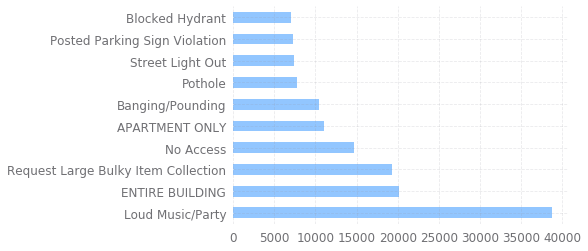

In [23]:
df['Descriptor'].value_counts().head(10).plot.barh()

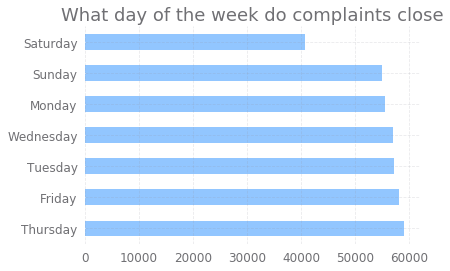

In [24]:
df['day of the week close'].value_counts().plot.barh( title= 'What day of the week do complaints close')

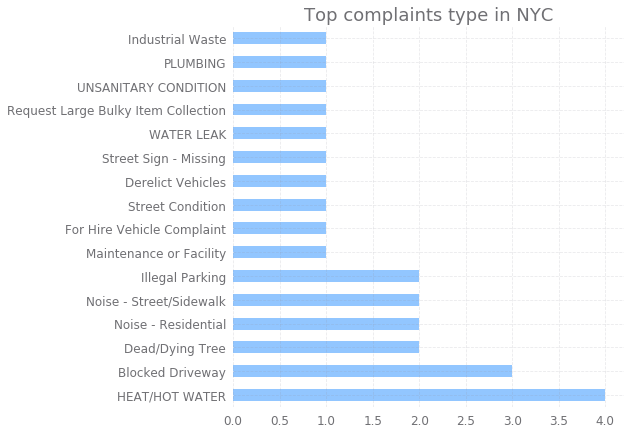

In [25]:
Count = pd.value_counts(df['Complaint Type'].head(25), sort=True)


Count.plot.barh( figsize=(7,7), rot = 0 ,title= 'Top complaints type in NYC')

In [26]:

df['Days to Close a Complaint' ].describe()

count    382188.000000
mean         14.519514
std          40.869971
min         -54.000000
25%           1.000000
50%           2.000000
75%           7.000000
max         395.000000
Name: Days to Close a Complaint, dtype: float64

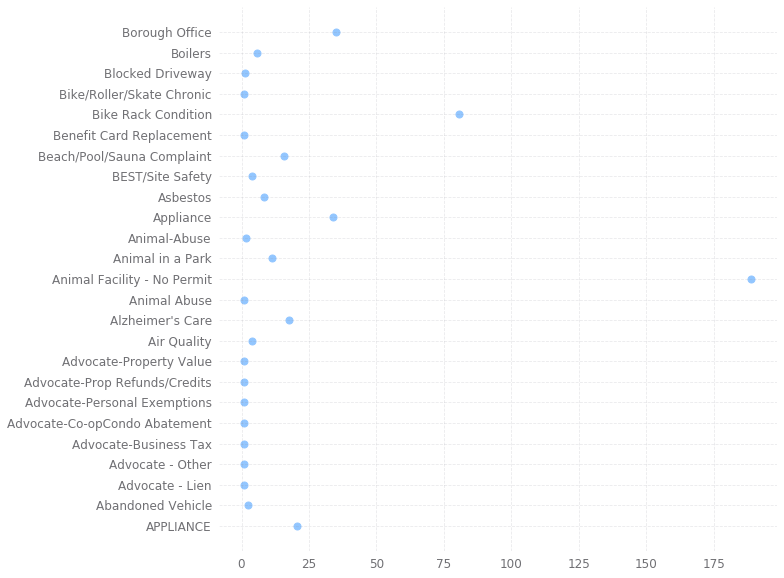

In [27]:


plt_scatter = df['Days to Close a Complaint' ].groupby(df['Complaint Type' ]).mean().head(25)
plt.figure(figsize=(10, 10) )
plt.scatter(plt_scatter, plt_scatter.index)



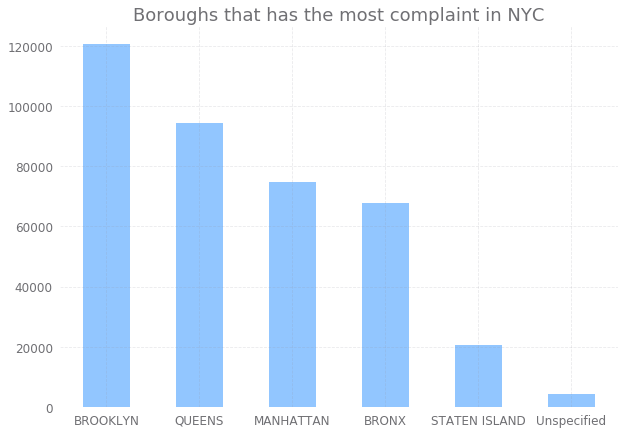

In [28]:
df['Borough'].value_counts().plot.bar( figsize=(10,7), rot = 0 , title = 'Boroughs that has the most complaint in NYC')
# what Borough has the most complaint in NYC

In [47]:
df['Borough'].value_counts().index

Index(['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND',
       'Unspecified'],
      dtype='object')

In [29]:
df_Borough = df[df['Borough']!='Unspecified']

In [30]:
df['Borough'].value_counts()/len(df['Borough'])*100

BROOKLYN         31.545731
QUEENS           24.719510
MANHATTAN        19.524946
BRONX            17.774498
STATEN ISLAND     5.356003
Unspecified       1.079312
Name: Borough, dtype: float64

In [31]:
df_Borough['Borough'].value_counts()/len(df_Borough['Borough'])*100

BROOKLYN         31.889923
QUEENS           24.989221
MANHATTAN        19.737980
BRONX            17.968434
STATEN ISLAND     5.414442
Name: Borough, dtype: float64

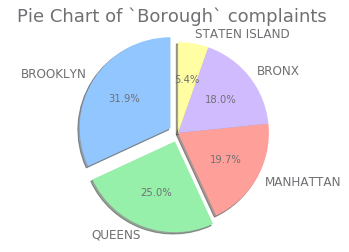

In [32]:
labels = 'BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND'
# define the sizes of the pie chart in percentages
#sizes = [55.1, 24.2, 20.7]
sizes = df_Borough['Borough'].value_counts()/len(df_Borough['Borough'])*100

# set which slice should be seperated/exploded from the other parts of the pie and how much
explode = (0.1,0.1, 0,0,0, )  # only "explode" the 1st slice

# Creates just a figure and only one subplot - from the matplotlib library which is a 2D plotting library
# source: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html
fig_Pclass, ax1 = plt.subplots()

# define the pie chart features, define sizes, explode, labels, autopct %, shadow, startangle
ax1.pie(sizes, labels=labels ,explode= explode , autopct='%1.1f%%', shadow=True, startangle=90)

# set the title of the pie chart and the aspect ratio to equal
ax1.set(aspect="equal", title='Pie Chart of `Borough` complaints ') # Equal aspect ratio ensures that pie is drawn as a circle.


#ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        #shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
#plt.tight_layout()
plt.show()
# Plot the Pie-chart of 'Pclass'
#plt.show()

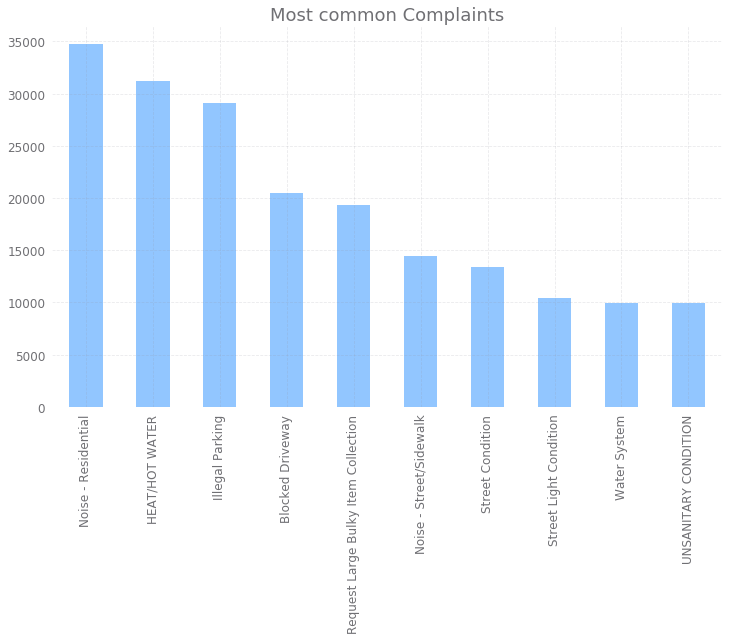

In [33]:
df['Complaint Type'].value_counts().head(10).plot(kind='bar',
                    figsize=(12,7), title = 'Most common Complaints')

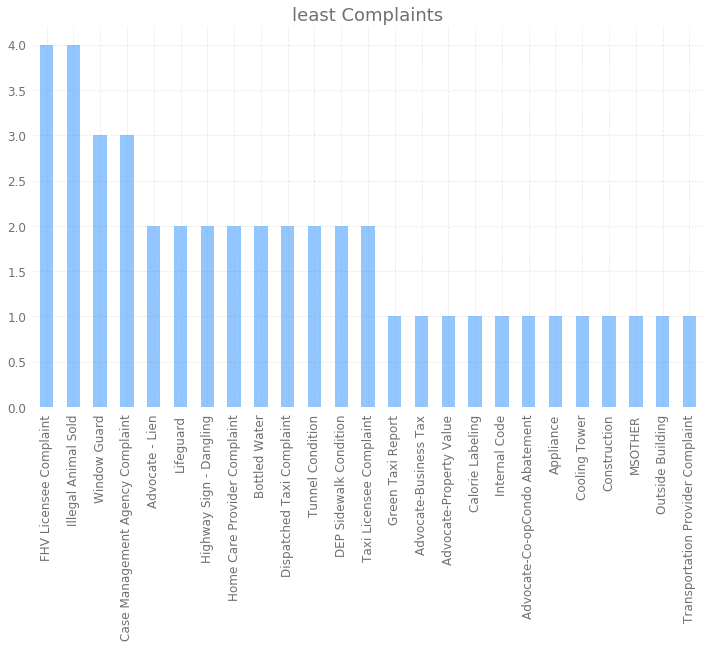

In [34]:
df['Complaint Type'].value_counts().tail(25).plot(kind='bar',
                    figsize=(12,7), title = 'least Complaints')

## setting up the heatmap with geopandas

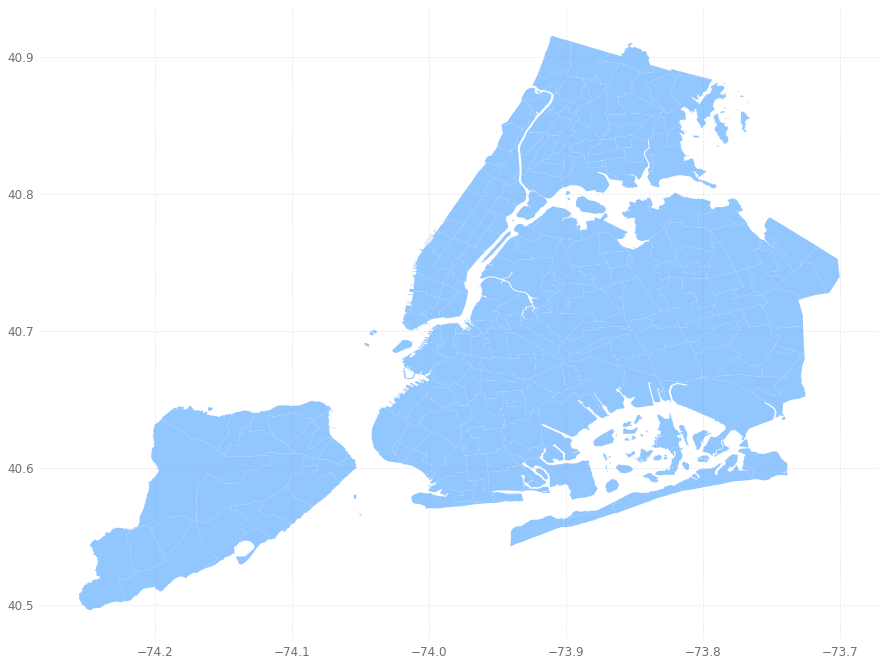

In [8]:
# I used this tutorial to prepare the data frame to geopandas
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
fig,ax = plt.subplots(figsize = (15,15))
map_df.plot(ax =ax)

In [9]:
geometry = [Point(xy) for xy in zip ( df["Longitude"] , df["Latitude"])]
geometry[:3]

In [10]:
geo_df = gpd.GeoDataFrame(df, crs = crs , geometry = geometry)
geo_df.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Resolution Description,Borough,Open Data Channel Type,Longitude,Latitude,geometry
Unique Key,,,,,,,,,,,,,,
40955843,11/16/2018 10:38:06 PM,11/20/2018 02:07:48 AM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10451,The Department of Housing Preservation and Dev...,BRONX,PHONE,-73.921346,40.829304,POINT (-73.92135 40.82930)
43346984,07/22/2019 02:28:34 AM,07/22/2019 09:10:37 PM,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10451,The Police Department responded to the complai...,BRONX,MOBILE,-73.917610,40.823165,POINT (-73.91761 40.82316)
42059386,03/26/2019 09:36:43 PM,03/27/2019 09:18:23 PM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10016,The Department of Housing Preservation and Dev...,MANHATTAN,PHONE,-73.982678,40.741938,POINT (-73.98268 40.74194)
43246439,07/10/2019 04:05:51 AM,07/10/2019 10:03:05 AM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11354,The Police Department issued a summons in resp...,QUEENS,PHONE,-73.827254,40.767053,POINT (-73.82725 40.76705)
42920377,06/09/2019 06:34:13 PM,06/09/2019 07:14:25 PM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10469,The Police Department responded to the complai...,BRONX,MOBILE,-73.846312,40.873051,POINT (-73.84631 40.87305)


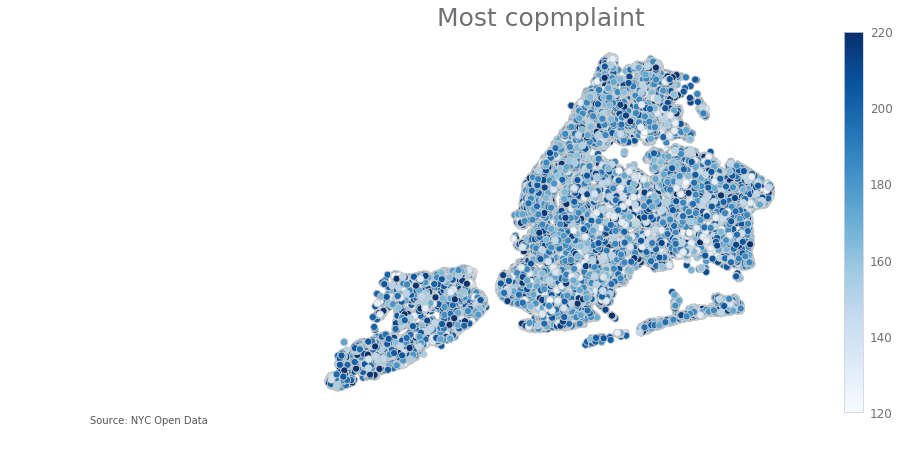

In [38]:
#https://github.com/bendoesdata/make-a-map-geopandas/blob/master/Let's%20make%20a%20map!%20Geopandas%20and%20Matplotlib.ipynb
# I used the tutorial above to set up the heatmap
# set a variable that will call whatever column we want to visualise on the map
variable = 'Complaint Type'

# set the range for the choropleth
vmin, vmax = 120, 220

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(17, 7))

# create map
geo_df.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Most copmplaint  ', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: NYC Open Data',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

In [11]:
# setting up the  heatmap using folium
heat_data = df.copy()

heat_data= heat_data[[ "Longitude" , "Latitude"]]

heat_data.isna().sum()

Longitude    22820
Latitude     22820
dtype: int64

In [12]:
#dropping messing values
heat_data.dropna(subset=['Latitude'], how='all', inplace=True)
heat_data.isna().sum()

Longitude    0
Latitude     0
dtype: int64

In [13]:
heat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359368 entries, 40955843 to 40741764
Data columns (total 2 columns):
Longitude    359368 non-null float64
Latitude     359368 non-null float64
dtypes: float64(2)
memory usage: 8.2 MB


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from folium import plugins
%matplotlib inline
#https://medium.com/@wesleywatanabe/using-python-matplotlib-pandas-and-folium-to-data-analysis-79299493c3e4
# Ensuring that its floats
heat_data['Latitude'] = heat_data['Latitude'].astype(float)
heat_data['Longitude'] = heat_data['Longitude'].astype(float)

coordinates =[]

# Setting lat and long 
lat = heat_data['Latitude']
long = heat_data['Longitude']
# Latitude and longitude that will open map. Here I put NYC
mapa = folium.Map(location=[40.693943, -73.985880]  ,tiles='cartodbpositron',  default_zoom_start=20) # base
# Append latitude and longitude coordinates array
for la,lo in zip(lat,long):
    coordinates.append([la,lo])
   
# We have about 359368 lines, but jupyter notebook ins't possible to show all these points.

# show onlye a piece
mapa.add_child(plugins.HeatMap(coordinates[0:38000],gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'},  max_zoom=17, radius=10, blur=15, overlay = False))

In [16]:
df.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Resolution Description,Borough,Open Data Channel Type,Longitude,Latitude,just_time_open,just_close,just_open,day of the week Open,day of the week close,Days to Close a Complaint,Month_open
Unique Key,,,,,,,,,,,,,,,,,,,,
40955843,11/16/2018 10:38:06 PM,11/20/2018 02:07:48 AM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10451,The Department of Housing Preservation and Dev...,BRONX,PHONE,-73.921346,40.829304,22:38:06,2018-11-20 02:07:48,2018-11-16 22:38:06,Friday,Tuesday,4.0,Nov
43346984,07/22/2019 02:28:34 AM,07/22/2019 09:10:37 PM,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10451,The Police Department responded to the complai...,BRONX,MOBILE,-73.917610,40.823165,02:28:34,2019-07-22 21:10:37,2019-07-22 02:28:34,Monday,Monday,1.0,Jul
42059386,03/26/2019 09:36:43 PM,03/27/2019 09:18:23 PM,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10016,The Department of Housing Preservation and Dev...,MANHATTAN,PHONE,-73.982678,40.741938,21:36:43,2019-03-27 21:18:23,2019-03-26 21:36:43,Tuesday,Wednesday,1.0,Mar
43246439,07/10/2019 04:05:51 AM,07/10/2019 10:03:05 AM,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11354,The Police Department issued a summons in resp...,QUEENS,PHONE,-73.827254,40.767053,04:05:51,2019-07-10 10:03:05,2019-07-10 04:05:51,Wednesday,Wednesday,1.0,Jul
42920377,06/09/2019 06:34:13 PM,06/09/2019 07:14:25 PM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10469,The Police Department responded to the complai...,BRONX,MOBILE,-73.846312,40.873051,18:34:13,2019-06-09 19:14:25,2019-06-09 18:34:13,Sunday,Sunday,1.0,Jun


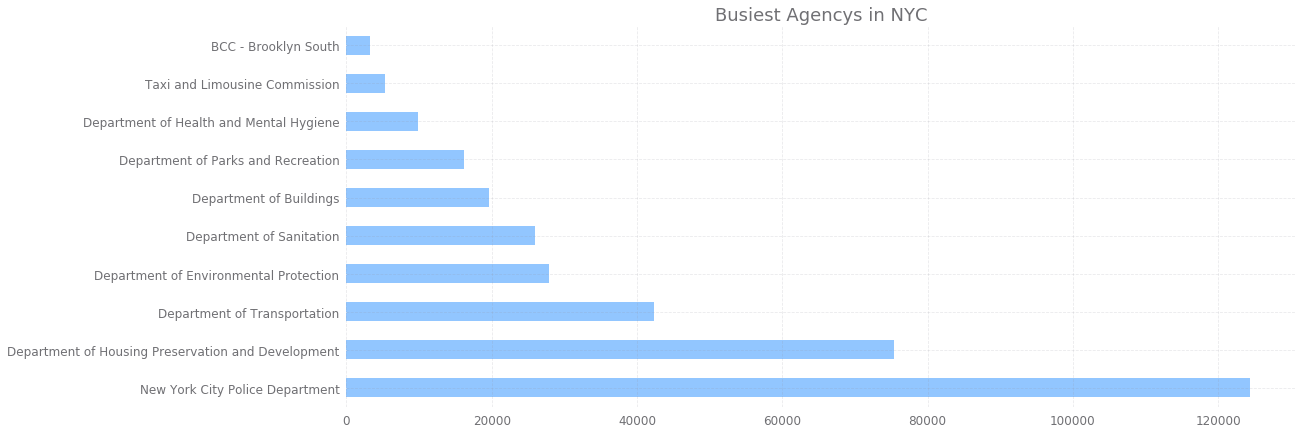

In [39]:
df['Agency Name'].value_counts().head(10).plot(kind='barh',
                    figsize=(17,7), title = 'Busiest Agencys in NYC')

In [40]:
#the sizes of the Agency series in percentages before grouping
df['Agency'].value_counts()/len(df['Agency'])*100

NYPD     32.568526
HPD      19.723801
DSNY     12.808879
DOT      11.065235
DEP       7.292223
DOB       5.130983
DPR       4.251834
DOHMH     2.584854
TLC       1.411609
DOF       1.170628
DHS       0.779721
DCA       0.614619
HRA       0.247522
DFTA      0.178708
EDC       0.087915
DOE       0.059918
DOITT     0.021717
NYCEM     0.001308
Name: Agency, dtype: float64

In [41]:
df['Agency'].value_counts().index

Index(['NYPD', 'HPD', 'DSNY', 'DOT', 'DEP', 'DOB', 'DPR', 'DOHMH', 'TLC',
       'DOF', 'DHS', 'DCA', 'HRA', 'DFTA', 'EDC', 'DOE', 'DOITT', 'NYCEM'],
      dtype='object')

In [42]:
filter_agancy_top5=['NYPD', 'HPD', 'DSNY', 'DOT', 'DEP']
filter_agancy_bottoms = [ 'DOB', 'DPR', 'DOHMH', 'TLC','DOF','DHS', 'DCA', 'HRA', 'DFTA', 'EDC', 'DOE', 'DCAS', 'DOITT','ACS', 'TAX', 'DVS', 'NYCEM', 'COIB']
agancy_top_5 = df[df['Agency'].isin(filter_agancy_top5)]
agancy_others = df[df['Agency'].isin(filter_agancy_bottoms)] 
agancy_others['Agency'] = "Other"
#agancy_other.tail()
agancy_clean_concat = pd.concat ([agancy_top_5 , agancy_others ])


/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [43]:
#the sizes of the Agency series in percentages after grouping the lowest percentage agancys
agancy_clean_concat['Agency'].value_counts()/len(agancy_clean_concat['Agency'])*100


NYPD     32.568526
HPD      19.723801
Other    16.541336
DSNY     12.808879
DOT      11.065235
DEP       7.292223
Name: Agency, dtype: float64

In [44]:
agancy_clean_concat['Agency'].value_counts().index

Index(['NYPD', 'HPD', 'Other', 'DSNY', 'DOT', 'DEP'], dtype='object')

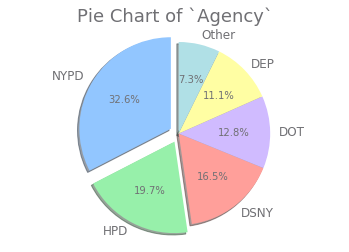

In [65]:
labels = 'NYPD', 'HPD', 'DSNY', 'DOT', 'DEP', 'Other'
# define the sizes of the pie chart in percentages
#sizes = [55.1, 24.2, 20.7]
sizes = agancy_clean_concat['Agency'].value_counts()/len(agancy_clean_concat['Agency'])*100

# set which slice should be seperated/exploded from the other parts of the pie and how much
explode = (0.1,0.1, 0,0,0, 0)  # only "explode" the 1st slice

# Creates just a figure and only one subplot - from the matplotlib library which is a 2D plotting library
# source: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html
fig_Pclass, ax1 = plt.subplots()

# define the pie chart features, define sizes, explode, labels, autopct %, shadow, startangle
ax1.pie(sizes, labels=labels ,explode= explode , autopct='%1.1f%%', shadow=True, startangle=90)

# set the title of the pie chart and the aspect ratio to equal
ax1.set(aspect="equal", title='Pie Chart of `Agency`') # Equal aspect ratio ensures that pie is drawn as a circle.


#ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        #shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
#plt.tight_layout()
plt.show()
# Plot the Pie-chart of 'Pclass'
#plt.show()

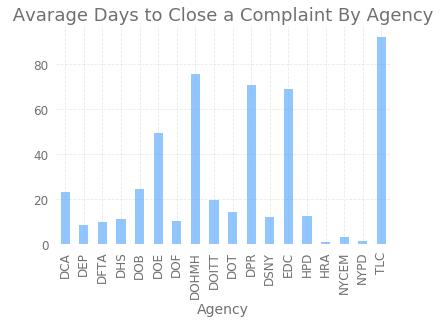

In [46]:
df['Days to Close a Complaint' ].groupby(df['Agency' ]).mean().plot.bar(title = ' Avarage Days to Close a Complaint By Agency ')

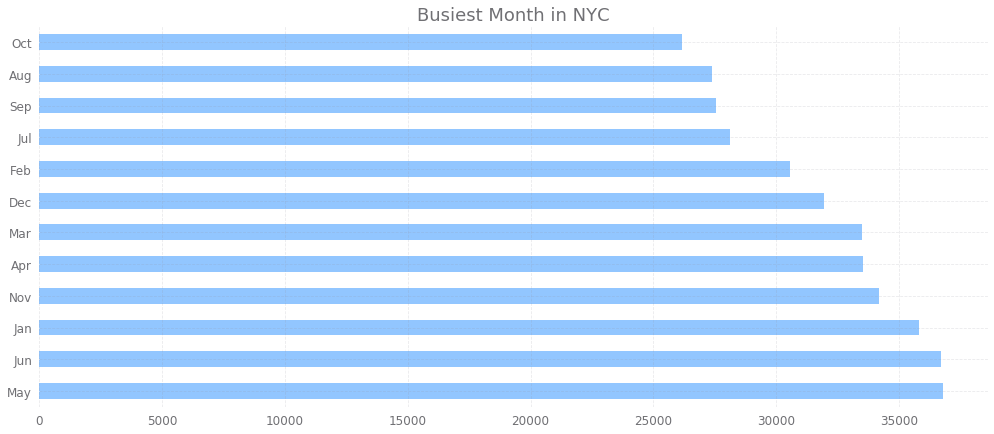

In [47]:
df['Month_open'].value_counts().plot(kind='barh',
                    figsize=(17,7), title = 'Busiest Month in NYC')

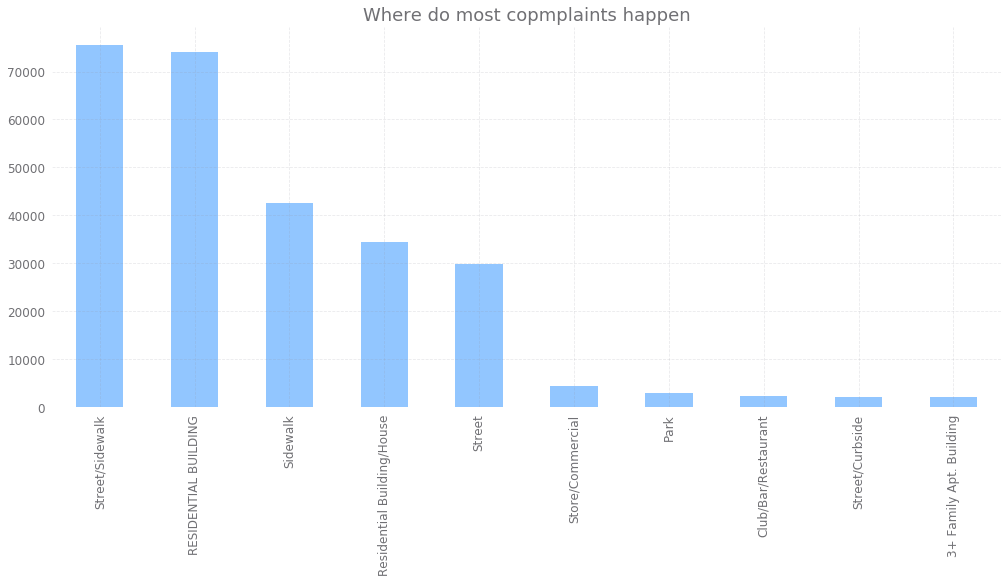

In [48]:
df['Location Type' ].value_counts().head(10).plot(kind='bar',
                    figsize=(17,7), title = 'Where do most copmplaints happen')

In [49]:
df_Brooklyn = df[df['Borough']=='BROOKLYN']

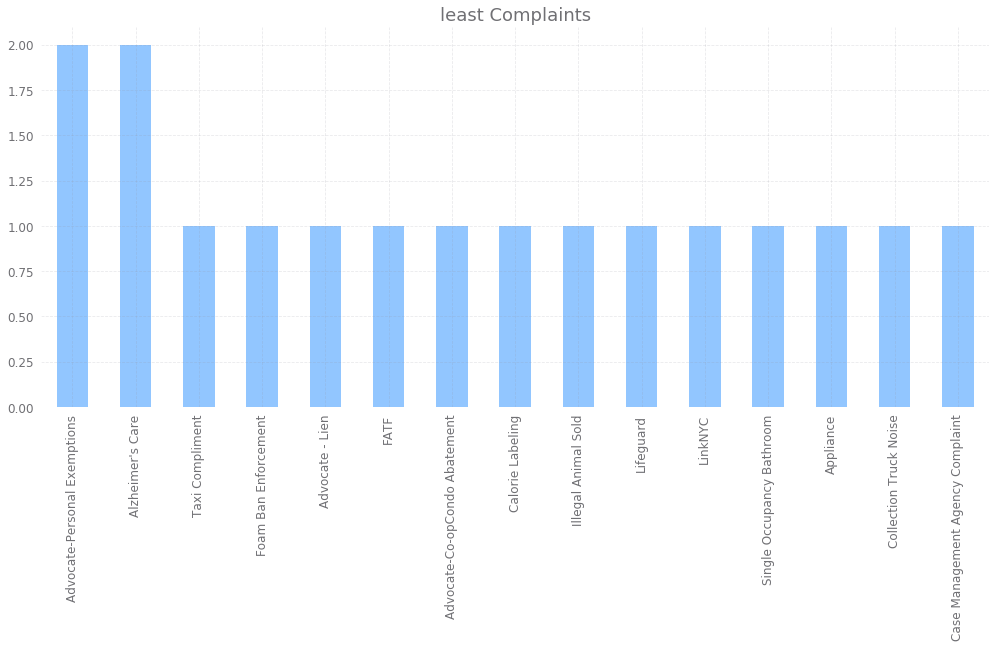

In [50]:
df_Brooklyn['Complaint Type'].value_counts().tail(15).plot(kind='bar',
                    figsize=(17,7), title = 'least Complaints')

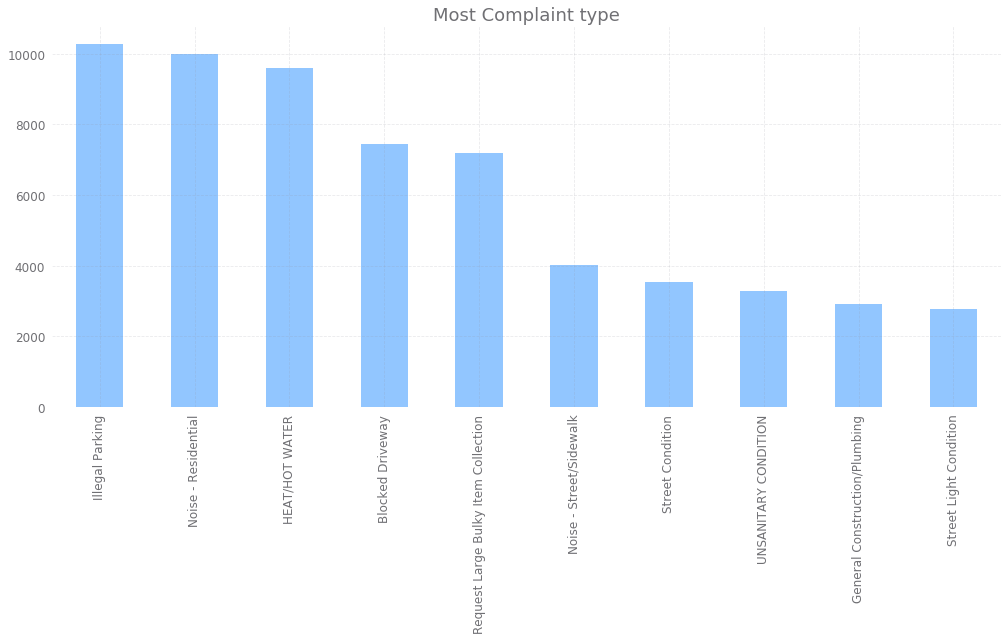

In [51]:
df_Brooklyn['Complaint Type'].value_counts().head(10).plot(kind='bar',
                    figsize=(17,7), title = 'Most Complaint type')

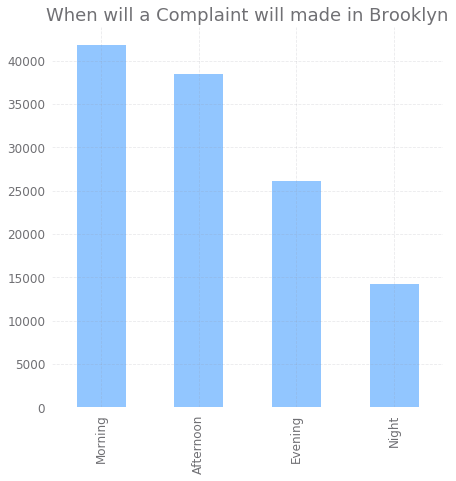

In [52]:
df_Brooklyn['Part of day open'].value_counts().head(25).plot(kind='bar',
                    figsize=(7,7), title = 'When will a Complaint will made in Brooklyn')

In [44]:
df_NYCPD=  df[df['Agency']=='NYPD']

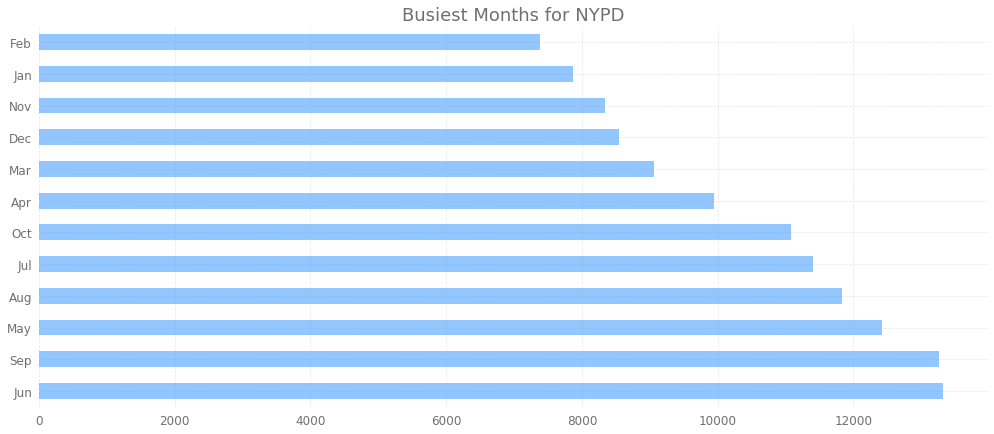

In [55]:
df_NYCPD['Month_open'].value_counts().plot(kind='barh',
                    figsize=(17,7), title = 'Busiest Months for NYPD')

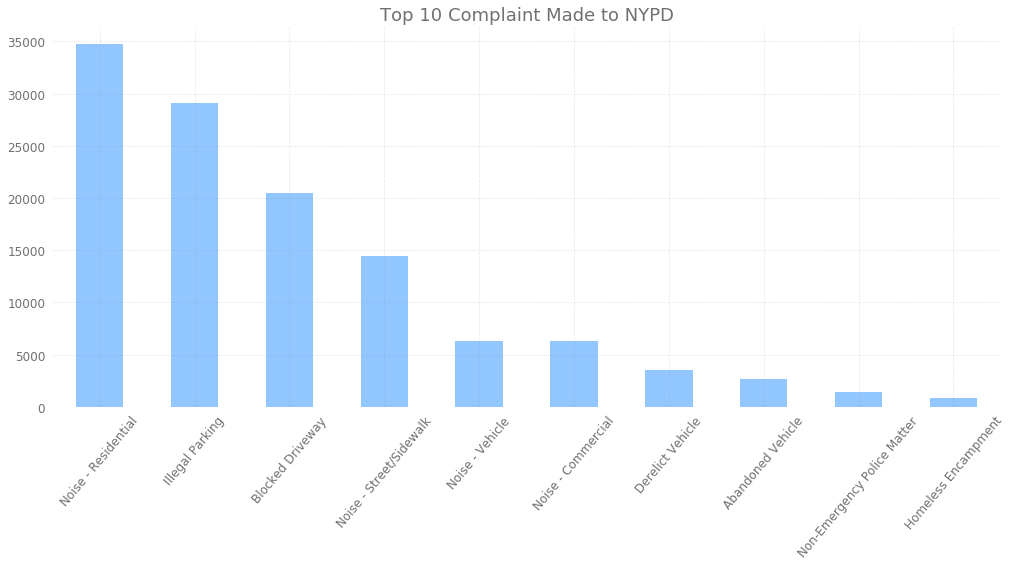

In [56]:
df_NYCPD['Complaint Type'].value_counts().head(10).plot(kind='bar',
                    figsize=(17,7), rot = 50, title = 'Top 10 Complaint Made to NYPD')

In [57]:
df_NYCPD['Days to Close a Complaint' ].groupby(df_NYCPD['Complaint Type' ]).mean()

Complaint Type
Abandoned Vehicle              2.459851
Animal Abuse                   1.042120
Animal-Abuse                   1.812796
Bike/Roller/Skate Chronic      1.010101
Blocked Driveway               1.300200
Derelict Vehicle               1.145263
Disorderly Youth               1.000000
Drinking                       1.186441
Drug Activity                  1.312139
Graffiti                       1.086207
Homeless Encampment            1.608894
Illegal Fireworks              1.535714
Illegal Parking                1.328166
Noise - Commercial             1.264673
Noise - House of Worship       1.333333
Noise - Park                   4.528926
Noise - Residential            1.253190
Noise - Street/Sidewalk        1.261800
Noise - Vehicle                1.193666
Non-Emergency Police Matter    1.492476
Panhandling                    1.007042
Posting Advertisement          1.000000
Traffic                        1.172275
Urinating in Public            1.152174
Vending                  

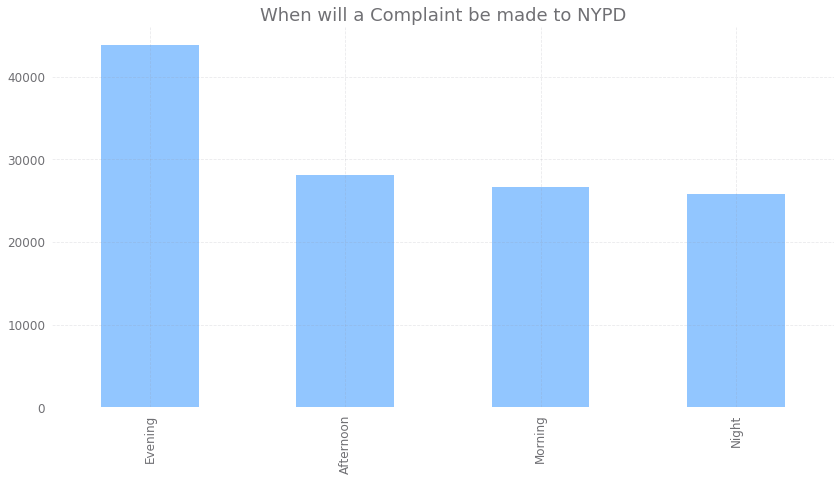

In [58]:
df_NYCPD['Part of day open'].value_counts().plot(kind='bar',
                    figsize=(14,7), title = 'When will a Complaint be made to NYPD')

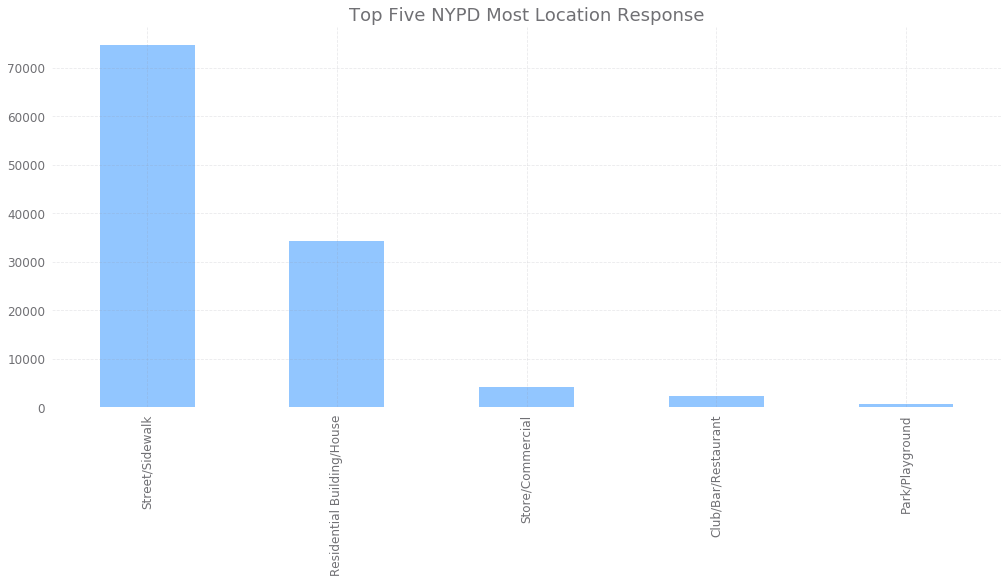

In [45]:
df_NYCPD['Location Type' ].value_counts().head(5).plot(kind='bar',
                    figsize=(17,7), title = 'Top Five NYPD Most Location Response')

### Word Cloud

<Figure size 2880x2160 with 0 Axes>

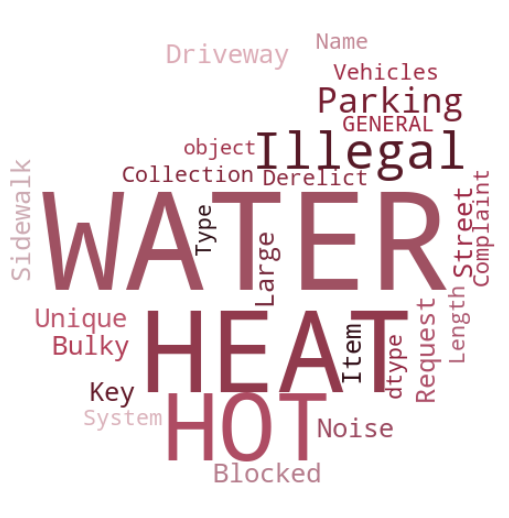

In [53]:
#https://medium.com/@dudsdu/an-example-of-word-cloud-with-mask-4cbbd699fb14
# source for  the word cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# source for the photo https://www.canstockphoto.com/new-york-the-big-apple-10983311.html
mask = np.array(Image.open("bigapple.jpg"))
text = df['Complaint Type']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white', mask = mask, max_words=27,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<Figure size 2880x2160 with 0 Axes>

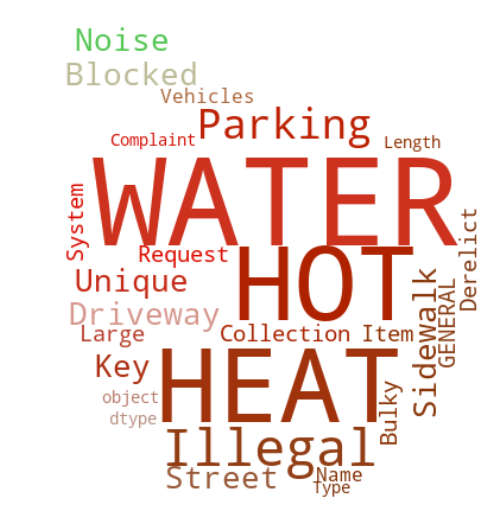

In [54]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# Seource for the photo https://wikiclipart.com/apple-clipart_453/
mask = np.array(Image.open("apple-free-downloads-clipart-red.jpg"))
text = df['Complaint Type']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white', mask = mask, 
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()